# Initialize True Map, Belief Map and Log Map

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from IPython.display import HTML
import time
%matplotlib inline

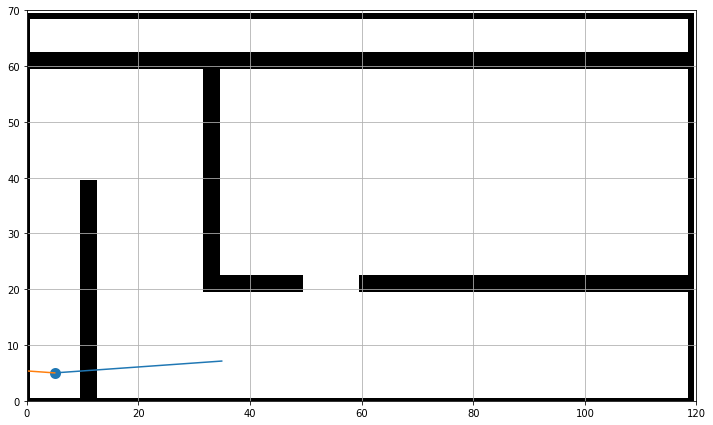

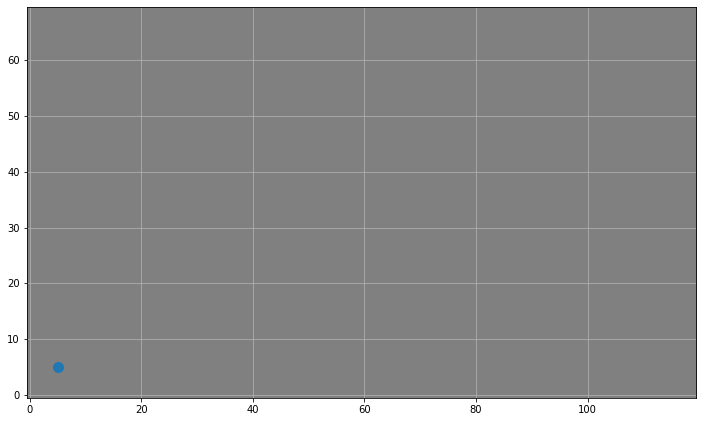

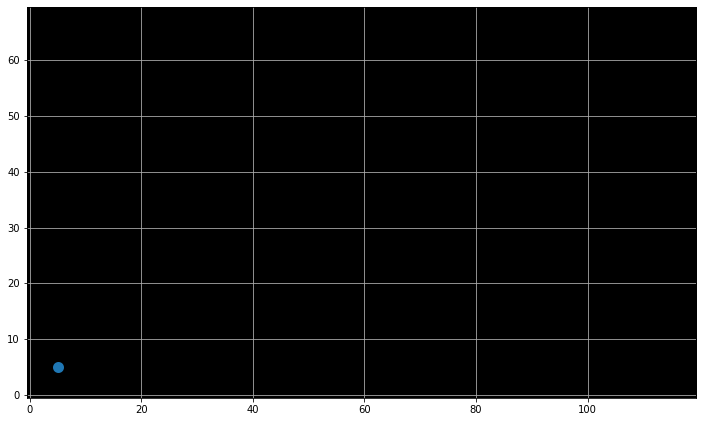

In [2]:
# Simulation time initialization.
T_MAX = 150

# Initializing the robot's location.
x_0 = [30, 30, 0, 0]  # 机器人初始未知,前三维分别是x,y,yaw,最后一维是时间序列

# map size
M = 70
N = 120

# Initialize the true map for perception
true_map = np.zeros((M, N)) 
# boundaries
true_map[0:70,0] = 1;
true_map[0:70,119] = 1;
true_map[0,0:120] = 1;
true_map[69,0:120] = 1;

# obstacles
true_map[0:40, 10:13] = 1
true_map[60:63, 0:120] = 1
true_map[20:60, 32:35] = 1
true_map[20:23, 32:50] = 1
true_map[20:23, 60:120] = 1


# Initialize the belief map.
# We are assuming a uniform prior.
m = np.multiply(0.5, np.ones((M, N)))

# Initialize the log odds ratio.
L0 = np.log(np.divide(m, np.subtract(1, m)))
L = L0

# sensor configuration,including the receptive field, angular resolution, max beam range, obstacle width
meas_phi_min = -1.5
meas_phi_max = 1.5
meas_phi_range = meas_phi_max - meas_phi_min
meas_phi_res = 0.05
meas_phi = np.arange(meas_phi_min, meas_phi_max, meas_phi_res)
rmax = 30  
alpha = 1


# Initialize the vector of states for our simulation.
# for 4 dimension (x, y, yaw, step)
x = np.zeros((4, 1000))
x[0, 0] = 5
x[1, 0] = 5
x[2, 0] = 0
x[3, 0] = 0


# true map to show=======================================================================================
true_fig = plt.figure(figsize=(12,10))
true_ax = true_fig.add_subplot(111)
true_ax.set_xlim(0, N) 
true_ax.set_ylim(0, M)
true_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
true_ax.grid(True)
true_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
# receptive field to show=======================================
x_max1_v = rmax * math.cos(meas_phi_range/2)
y_max1_v = rmax * math.sin(meas_phi_range/2)
x_max1_m = x_max1_v * math.cos(0) - y_max1_v * math.sin(0) + x[0, 0]
y_max1_m = x_max1_v * math.sin(0) + y_max1_v * math.cos(0) + x[1, 0]
x_max2_v = rmax * math.cos(meas_phi_range/2)
y_max2_v = rmax * math.sin(-meas_phi_range/2)
x_max2_m = x_max2_v * math.cos(0) - y_max2_v * math.sin(0) + x[0, 0]
y_max2_m = x_max2_v * math.sin(0) + y_max2_v * math.cos(0) + x[1, 0]
true_ax.plot([x[1, 0],y_max1_m],[x[0, 0], x_max1_m])
true_ax.plot([x[1, 0],y_max2_m],[x[0, 0], x_max2_m])

# belief map to show=======================================================================================
prob_fig = plt.figure(figsize=(12,10))
prob_ax = prob_fig.add_subplot(111)
prob_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
prob_ax.grid(True)
prob_ax.imshow(m, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
# log map to show=======================================================================================
log_fig = plt.figure(figsize=(12,10))
log_ax = log_fig.add_subplot(111)
log_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
log_ax.grid(True)
log_ax.imshow(L, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)

In [3]:
# step = 0 for simulation start
step = 0

# Some Tiny Tools

In [4]:
# Bresenham
import copy

def GenericBresenhamLine(x1, y1, x2, y2):
    ray_list = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    s1 = 1 if ((x2 - x1) > 0) else -1
    s2 = 1 if ((y2 - y1) > 0) else -1
    boolInterChange = False
    if dy > dx:
        # np.swapaxes(dx, dy)
        tmp = copy.deepcopy(dx)
        dx = copy.deepcopy(dy)
        dy = copy.deepcopy(tmp)

        boolInterChange = True
    e = 2 * dy - dx
    x = x1
    y = y1
    for i in range(0, int(dx + 1)):
        ray_list.append([x,y])
        if e >= 0:
            if boolInterChange:
                x += s1
            else:
                y += s2
            e -= 2 * dx
        if boolInterChange:
            y += s2
        else:
            x += s1
        e += 2 * dy
    return ray_list

(1189, 2)


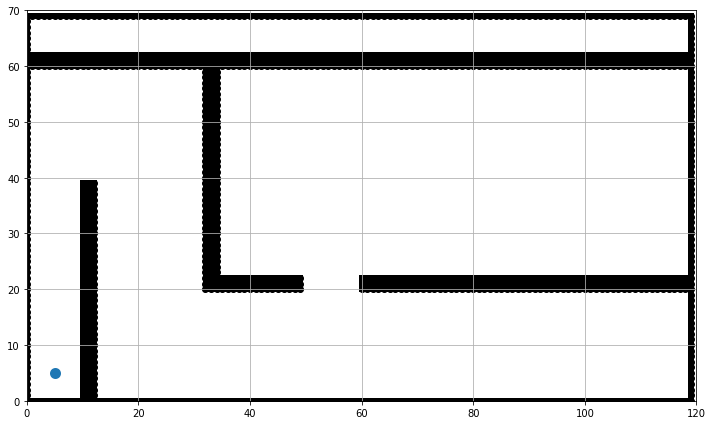

In [5]:
# produce obstacle points
# true_map[0:70,0] = 1;
# true_map[0:70,119] = 1;
# true_map[0,0:120] = 1;
# true_map[69,0:120] = 1;

# true_map[0:40, 10:13] = 1
# true_map[60:63, 0:120] = 1
# true_map[20:60, 32:35] = 1
# true_map[20:23, 32:50] = 1
# true_map[20:23, 60:120] = 1
obs_list=[]
for i in range(M):
  for j in range(N):
    if (i>=0 and i<40 and j>=10 and j<13) or (i>=60 and i<63 and j>=0 and j<120) or (i>=20 and i<60 and j>=32 and j<35)\
      or (i>=20 and i<23 and j>=32 and j<50) or (i>=20 and i<23 and j>=60 and j<120) or (i>=0 and i<70 and j==0) \
       or (i>=0 and i<100 and j==119)  or (i==0 and j>=0 and j<120) or (i==69 and j>=0 and j<120):
     obs_list.append([i,j])
obs_array = np.array(obs_list)
print(obs_array.shape)


# show obstacles
true_fig = plt.figure(figsize=(12,10))
true_ax = true_fig.add_subplot(111)
true_ax.set_xlim(0, N)
true_ax.set_ylim(0, M)
true_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
true_ax.grid(True)
true_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
for obs in obs_list:
  true_ax.scatter(obs[1],obs[0],color='black',linewidths=1)



In [6]:
extend_list=[] # the map points (which are perceived in our map)
def ray_casting(x):
  extend_list_this_time = []
  loop = 0
  for theta in np.arange(meas_phi_min,meas_phi_max,meas_phi_res):
    break_flag = 0
    theta_m = x[2, step]
    x_v = rmax * math.cos(theta)
    y_v = rmax * math.sin(theta)
    x_m = x_v * math.cos(theta_m) - y_v * math.sin(theta_m) + x[0, step]
    y_m = x_v * math.sin(theta_m) + y_v * math.cos(theta_m) + x[1, step]
    ray_array = np.array(GenericBresenhamLine(x[0, step],x[1, step], x_m,y_m))
    for p in range(ray_array.shape[0]):
      free_flag = 1
      for obs_index in range(obs_array.shape[0]):
        dist_vec = ray_array[p] - obs_array[obs_index]  
        if math.hypot(dist_vec[0],dist_vec[1]) > alpha-0.1: # not obstacle point
          continue
        else:
          break_flag = 1
          free_flag = 0
          break
      if free_flag == 1:
        if (int(ray_array[p,0]) < M and int(ray_array[p,1]) < N):
          L[int(ray_array[p,0]), int(ray_array[p,1])] = L[int(ray_array[p,0]), int(ray_array[p,1])]-0.05
          if L[int(ray_array[p,0]), int(ray_array[p,1])]<-0.2:
            L[int(ray_array[p,0]), int(ray_array[p,1])] = -0.2
          extend_list.append(ray_array[p])
          extend_list_this_time.append(ray_array[p])
      if break_flag == 1:
        if (int(ray_array[p,0]) < M and int(ray_array[p,1]) < N):
          L[int(ray_array[p,0]), int(ray_array[p,1])] = L[int(ray_array[p,0]), int(ray_array[p,1])]+0.1
          extend_list.append(ray_array[p])
          extend_list_this_time.append(ray_array[p])
        break
  return extend_list_this_time

# Small Test

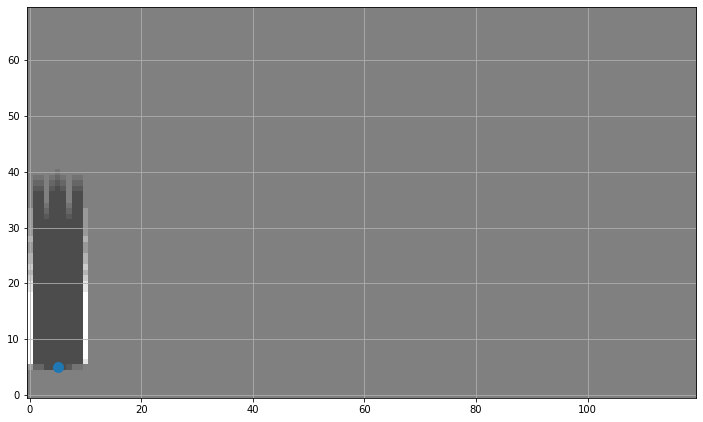

In [7]:
log_fig = plt.figure(figsize=(12,10))
log_ax = log_fig.add_subplot(111)
log_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
log_ax.grid(True)

ray_casting(x)
# a simple scene in which the robot goes forward 5 steps without yaw changes
for count in range(5):
  step = step + 1
  x[0,step] = x[0,step-1]+1
  x[1,step] = x[1,step-1]    
  x[2,step] = x[2,step-1] 
  extended_this = ray_casting(x)
log_ax.imshow(L+0.5, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)

# Information Theoretical Exploration
reference: https://ieeexplore.ieee.org/document/7759289

Here we use MI-based algorithm to explore the environments. The ref paper proposed a classic method and has a good guiding significance for active slamer, which combined Gaussian Process (GPs) and Bayesian Optimization (BO) to search the trajectory.

In [8]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
import random

In [9]:
def removeSameExtend( extlist ):
  extlist_new = []
  for point1 in extlist:
    flag = 0
    for point2 in extlist_new:
      if ((point1 == point2).all()):
        flag = 1
    if flag==0:
      extlist_new.append(point1)
  return extlist_new

In [10]:
# calculate entropy of map
def cal_Hm(L_):
  H_m_ = 0
  for xx in range(M):
    for yy in range(N):
      p_l = math.exp(L_[xx, yy])/(1+math.exp(L_[xx, yy]))
      hm = p_l * np.log(p_l)
      H_m_ = H_m_ + hm
  return H_m_

In [11]:
# not true ray casting
# virtual raycasting is used to calculate mutual information based on the current map and 
# it doesn't influence the probability distribution of the current map
# Why I build 2 different functions for ray casting is for avoidance of spurious use
def ray_casting_virtual(x, L_co):

  obs_list_virtual = []
  extend_list_virtual = []
  for x_virtual in range(M):
    for y_virtual in range(N):
      if L_co[x_virtual,y_virtual] > 0: 
        obs_list_virtual.append([x_virtual,y_virtual])

  obs_array = np.array(obs_list_virtual)
  for theta in np.arange(meas_phi_min,meas_phi_max,meas_phi_res):
    break_flag = 0
    # theta_m = theta + x[2, step]
    theta_m = x[2, step]
    x_v = rmax * math.cos(theta)
    y_v = rmax * math.sin(theta)
    x_m = x_v * math.cos(theta_m) - y_v * math.sin(theta_m) + x[0, step]
    y_m = x_v * math.sin(theta_m) + y_v * math.cos(theta_m) + x[1, step]
    ray_array = np.array(GenericBresenhamLine(x[0, step],x[1, step], x_m,y_m))
    for p in range(ray_array.shape[0]):
      free_flag = 1
      for obs_index in range(obs_array.shape[0]):
        dist_vec = ray_array[p] - obs_array[obs_index]   
        if math.hypot(dist_vec[0],dist_vec[1]) > alpha-0.1: 
          continue
        else:
          break_flag = 1
          free_flag = 0
          break
      if free_flag == 1:
        if (int(ray_array[p,0]) < M and int(ray_array[p,1]) < N and int(ray_array[p,0])>0 and int(ray_array[p,1])>0):
          L_co[int(ray_array[p,0]), int(ray_array[p,1])] = L_co[int(ray_array[p,0]), int(ray_array[p,1])]-0.05
          if L_co[int(ray_array[p,0]), int(ray_array[p,1])]<-2:   
            L_co[int(ray_array[p,0]), int(ray_array[p,1])] = -2
          extend_list_virtual.append(ray_array[p])
      if break_flag == 1:
        if (int(ray_array[p,0]) < M and int(ray_array[p,1]) < N and int(ray_array[p,0])>0 and int(ray_array[p,1])>0):
          # L_co[int(ray_array[p,0]), int(ray_array[p,1])] = L_co[int(ray_array[p,0]), int(ray_array[p,1])]+0.06
          # if L_co[int(ray_array[p,0]), int(ray_array[p,1])]>0.2:
          #   L_co[int(ray_array[p,0]), int(ray_array[p,1])] = 0.2
          extend_list_virtual.append(ray_array[p])
        break
  return L_co

time consuming of frontier capture： 15.70495343208313
time consuming of candidate capture： 4.224977731704712
time consuming of frontier capture： 29.665106058120728
time consuming of candidate capture： 31.529306173324585
time consuming of frontier capture： 43.94117069244385
time consuming of candidate capture： 28.253297805786133
time consuming of frontier capture： 56.31990885734558
time consuming of candidate capture： 106.83622479438782
time consuming of frontier capture： 63.6802179813385
time consuming of candidate capture： 311.15438747406006
time consuming of frontier capture： 83.18400740623474
time consuming of candidate capture： 298.5415644645691
time consuming of frontier capture： 74.14901995658875
time consuming of candidate capture： 119.64456462860107
time consuming of frontier capture： 62.03032302856445
time consuming of candidate capture： 364.25620102882385
time consuming of frontier capture： 103.51978039741516
time consuming of candidate capture： 599.4653859138489
time consumi

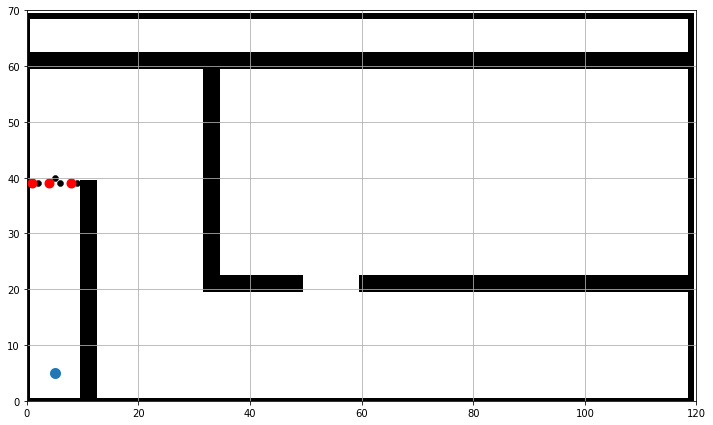

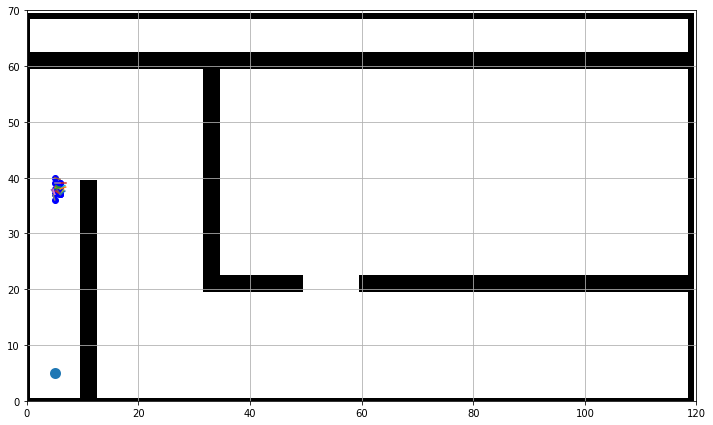

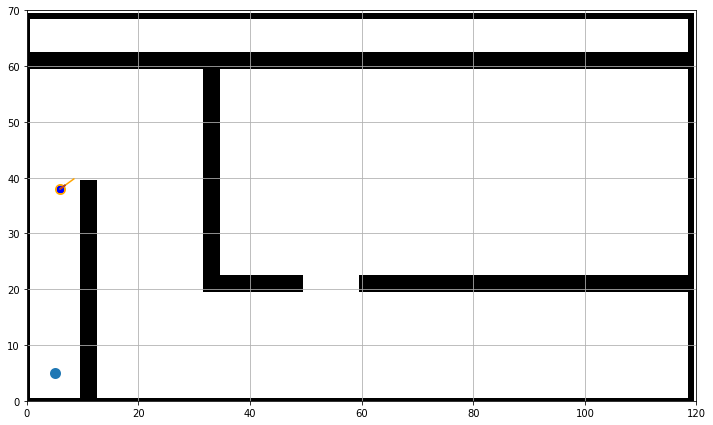

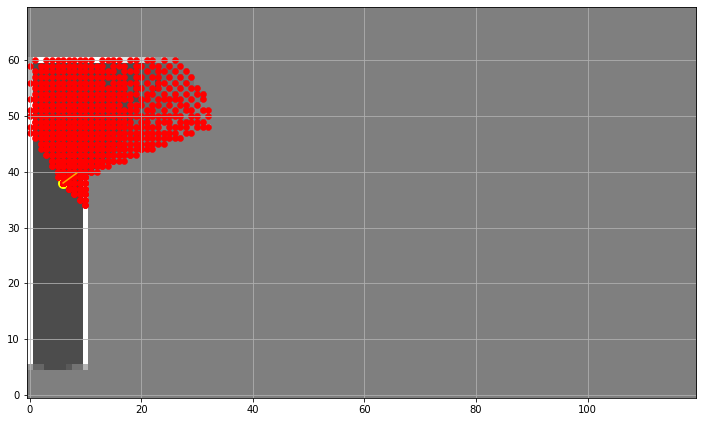

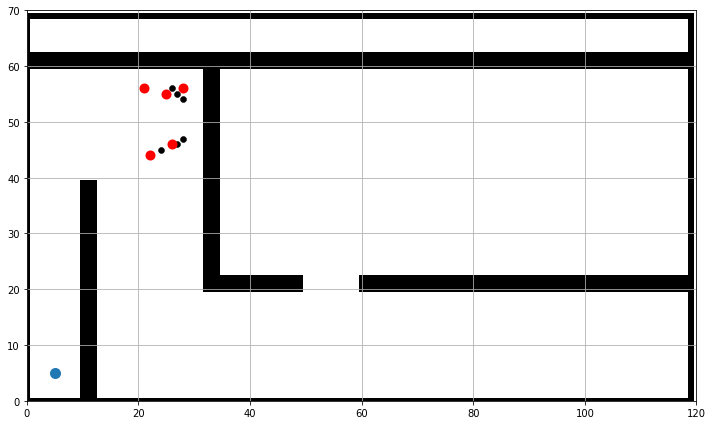

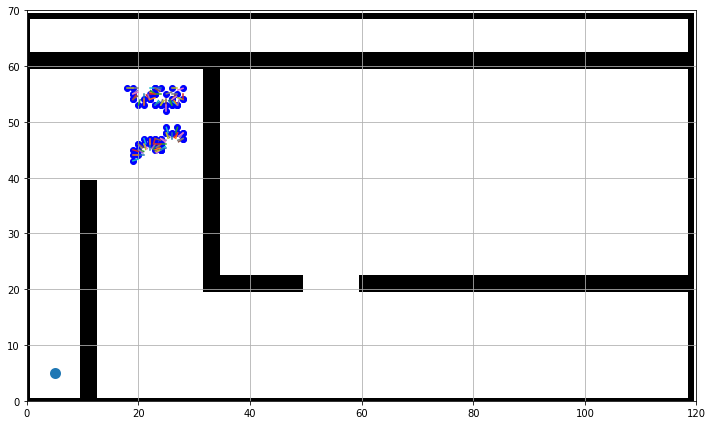

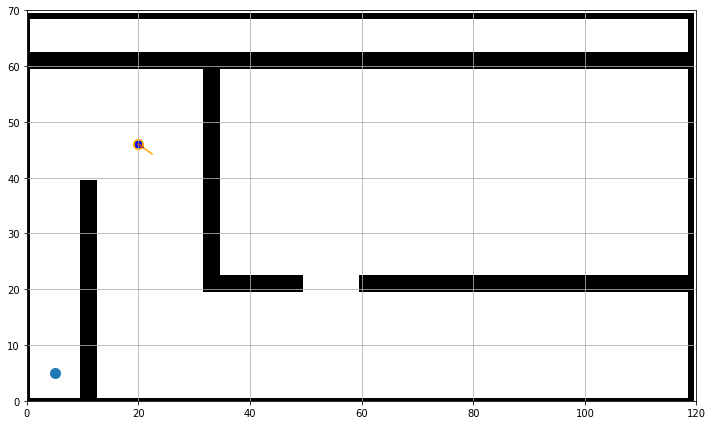

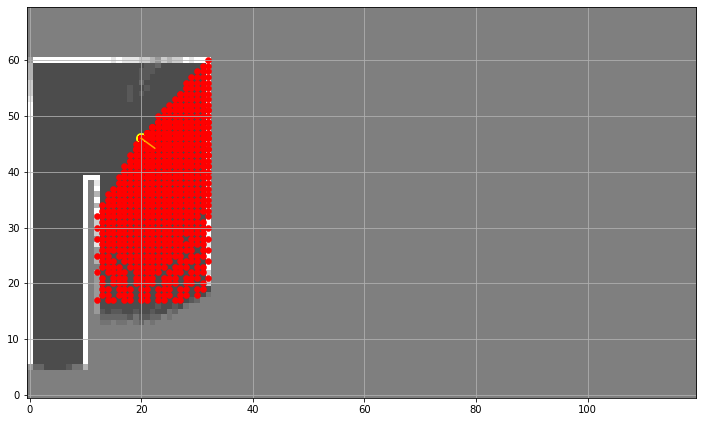

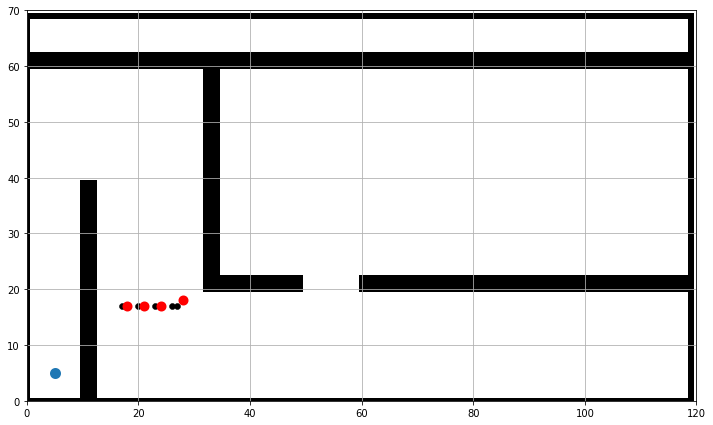

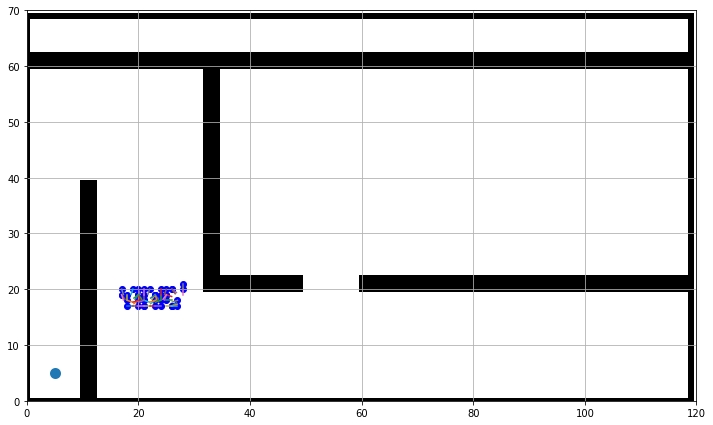

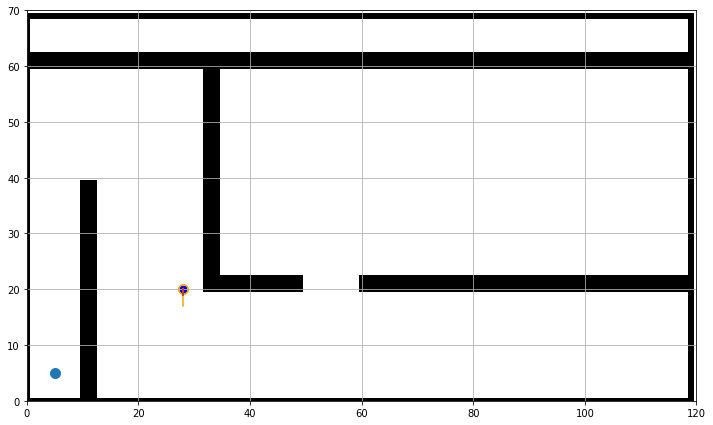

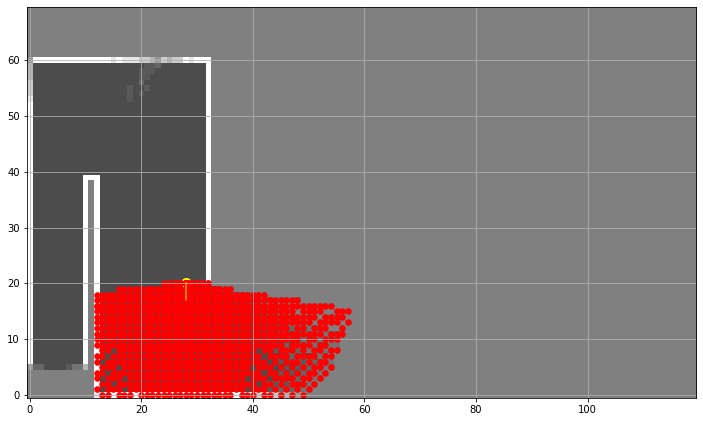

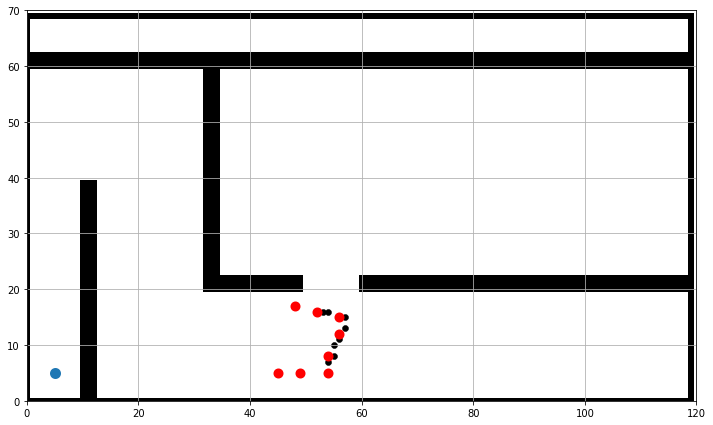

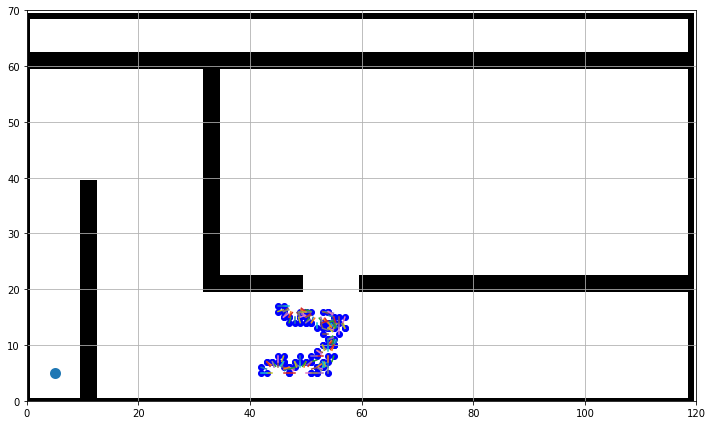

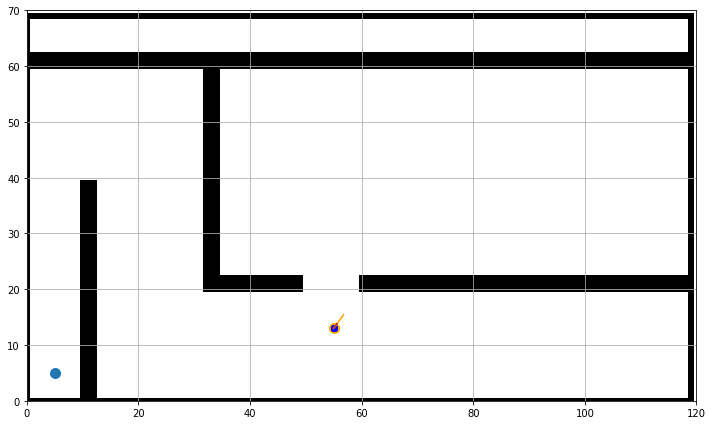

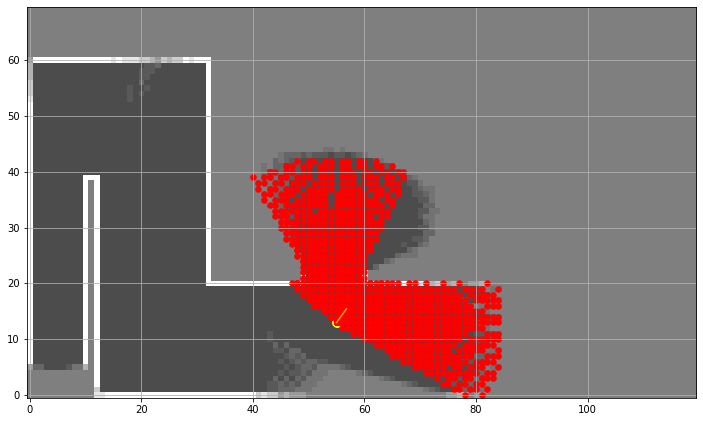

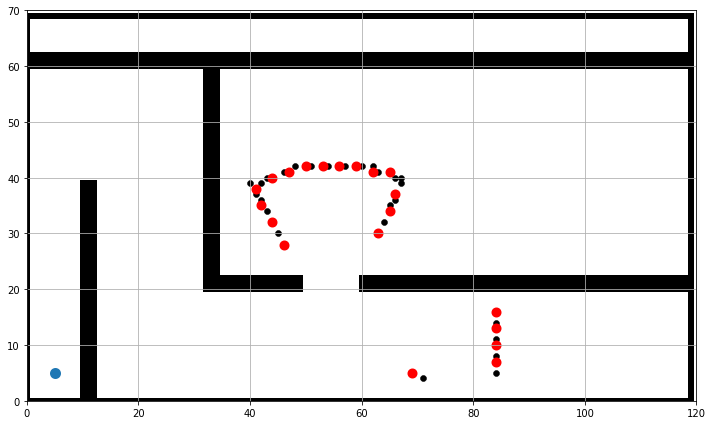

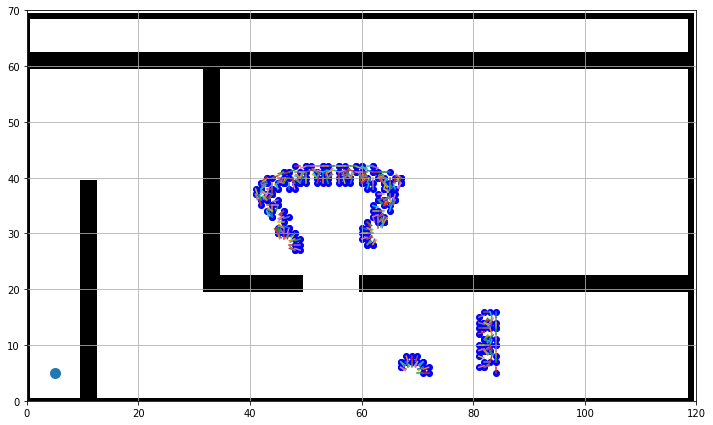

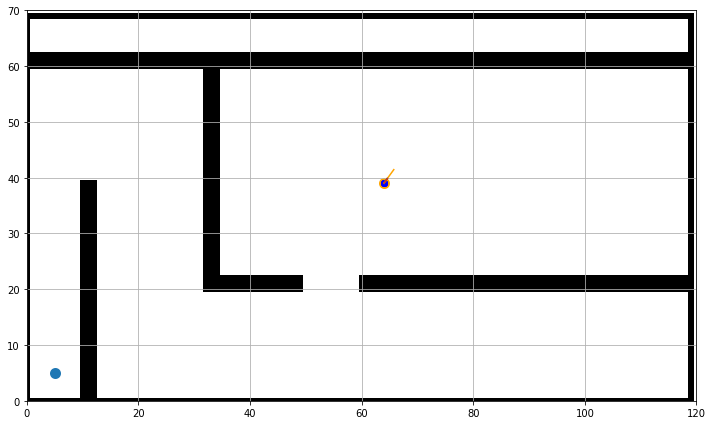

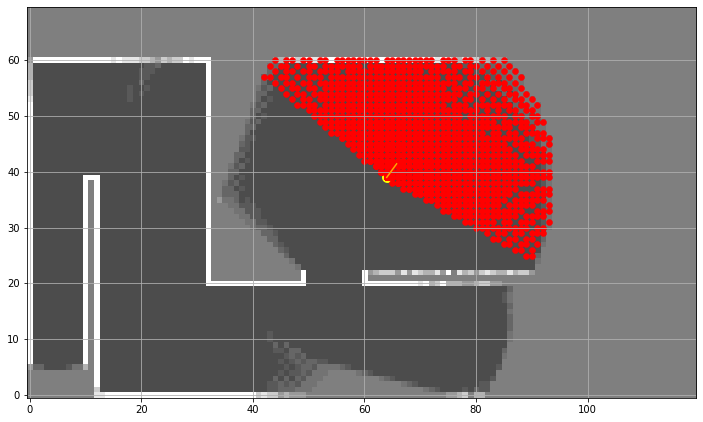

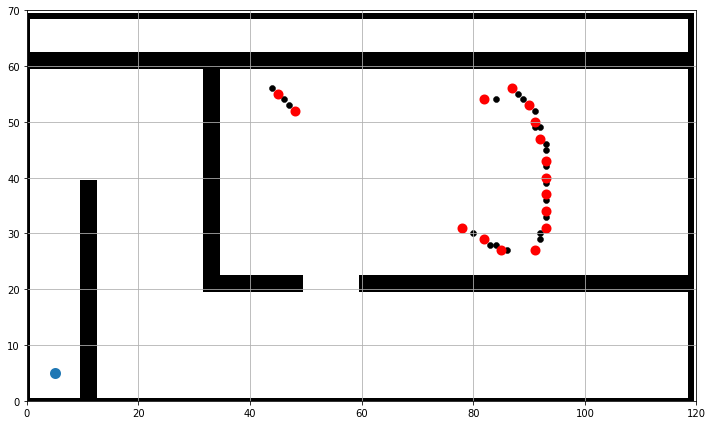

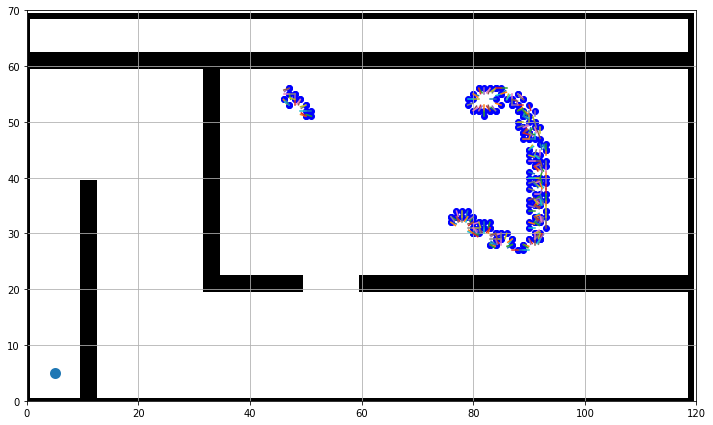

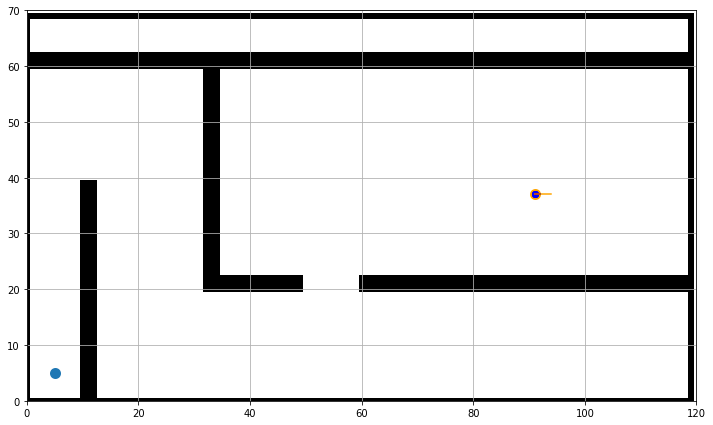

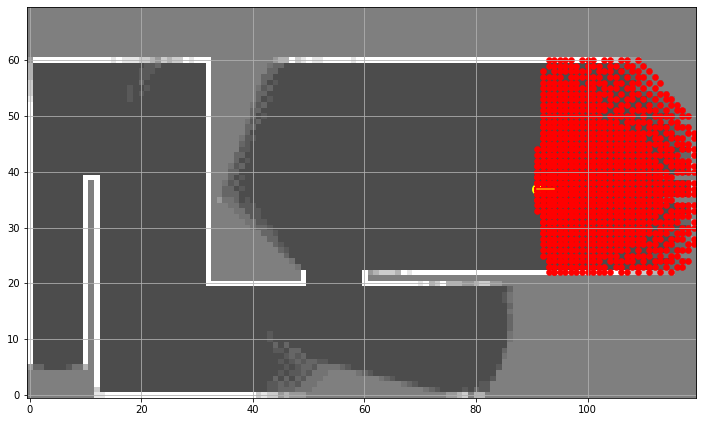

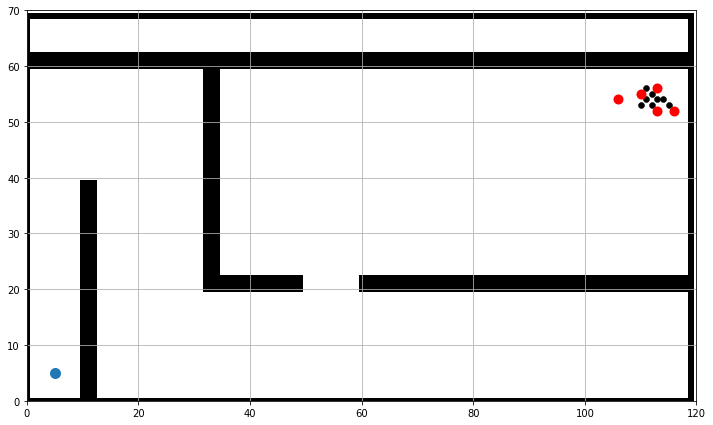

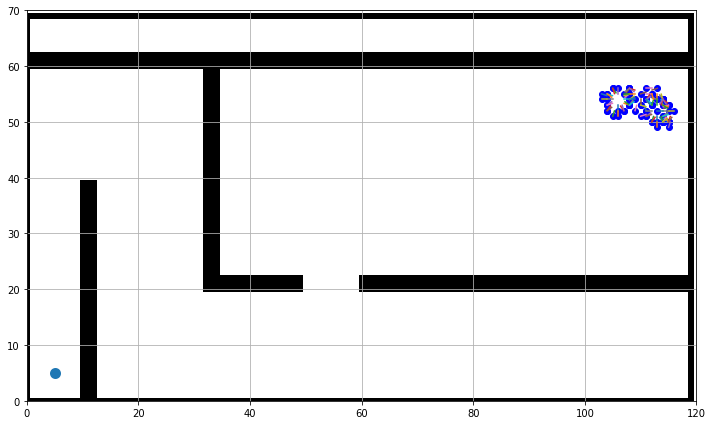

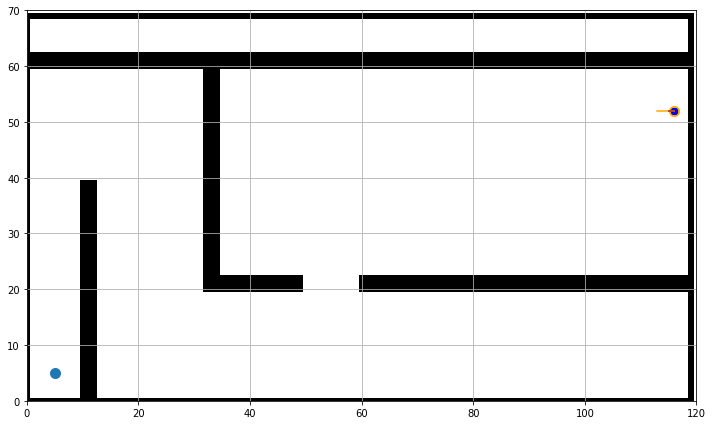

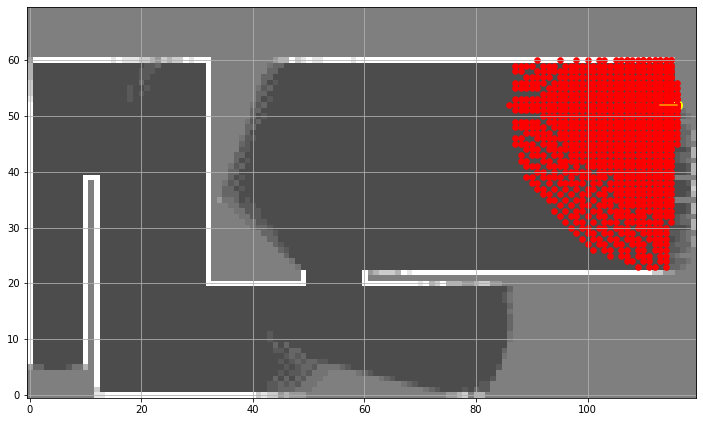

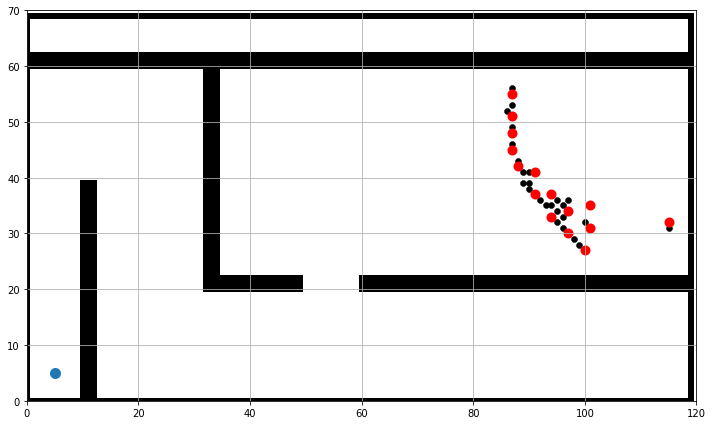

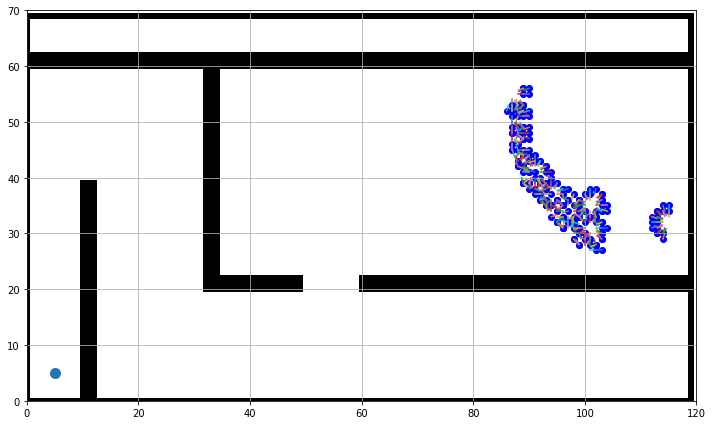

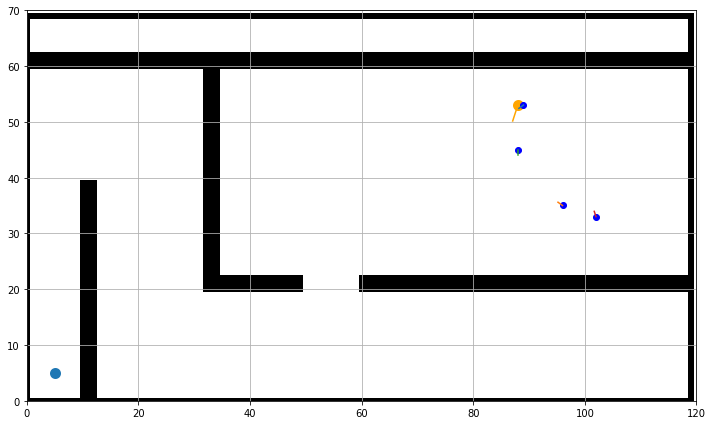

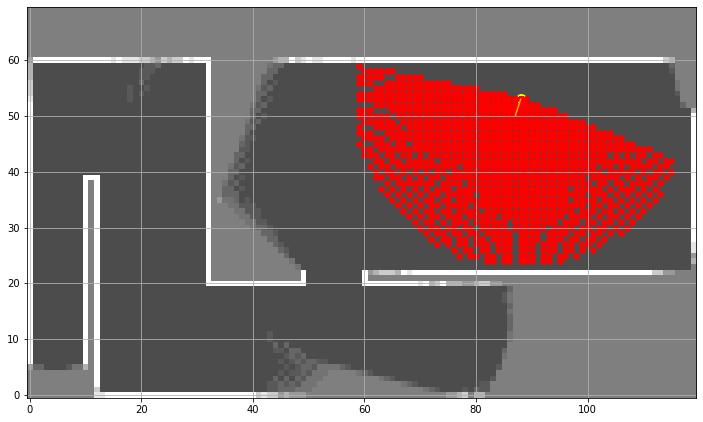

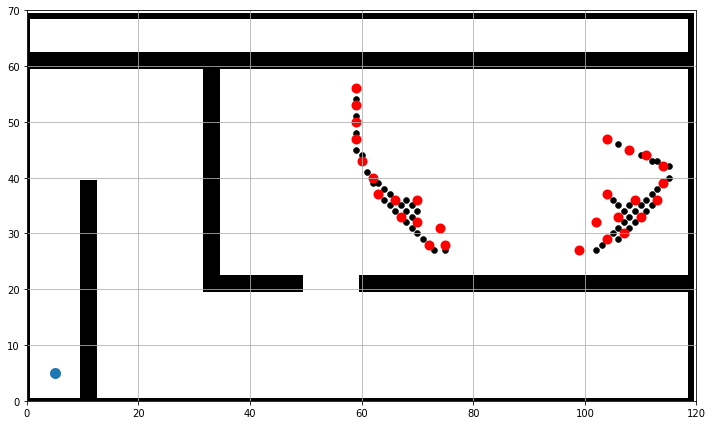

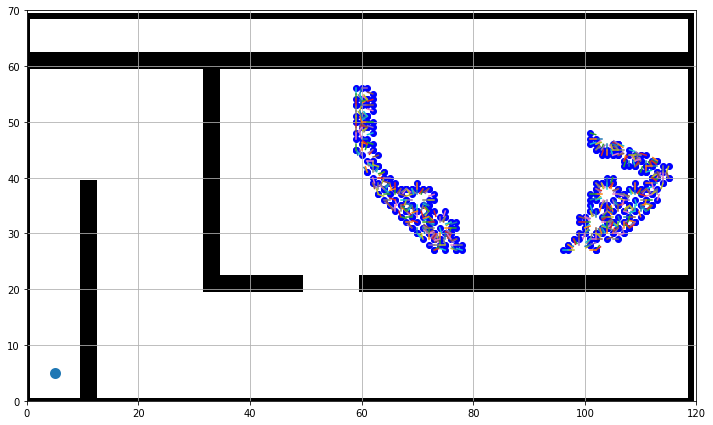

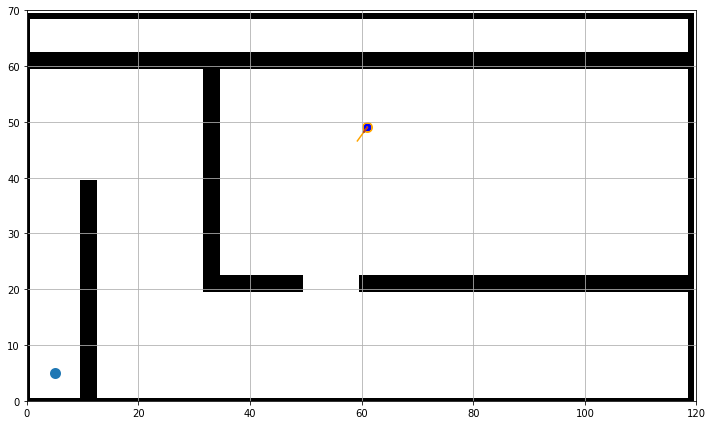

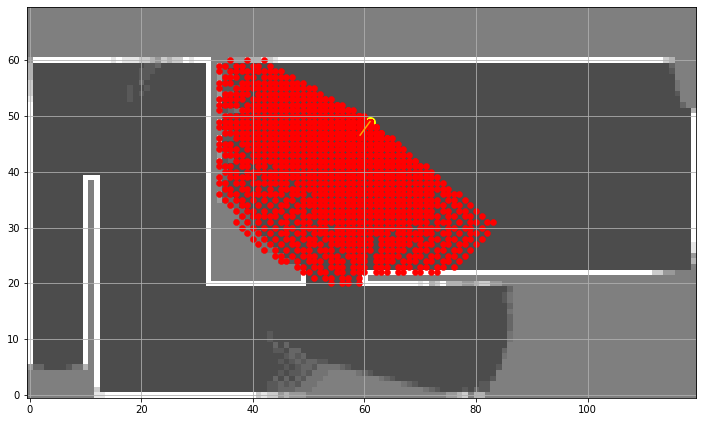

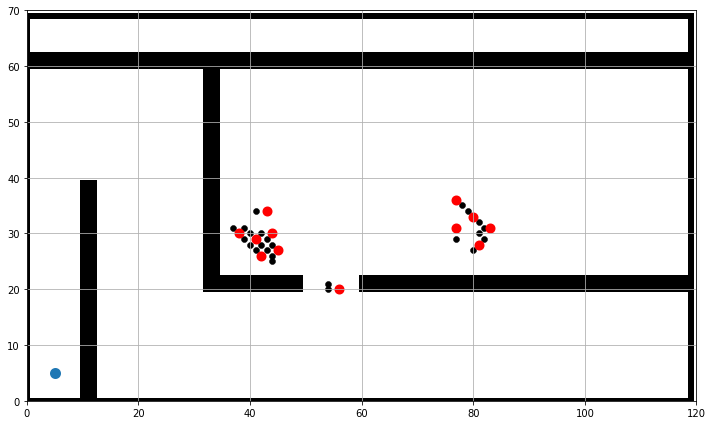

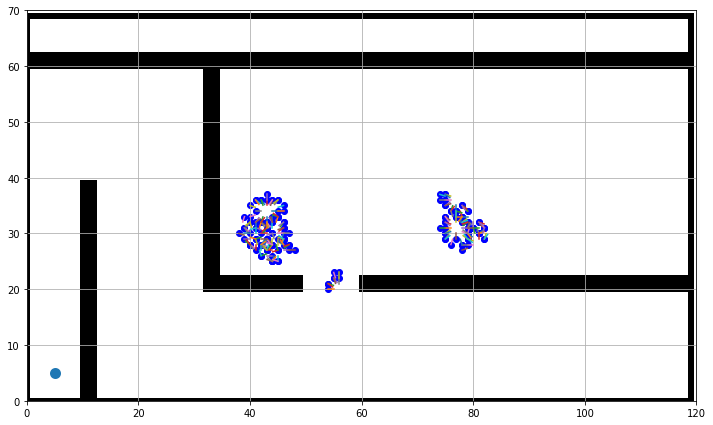

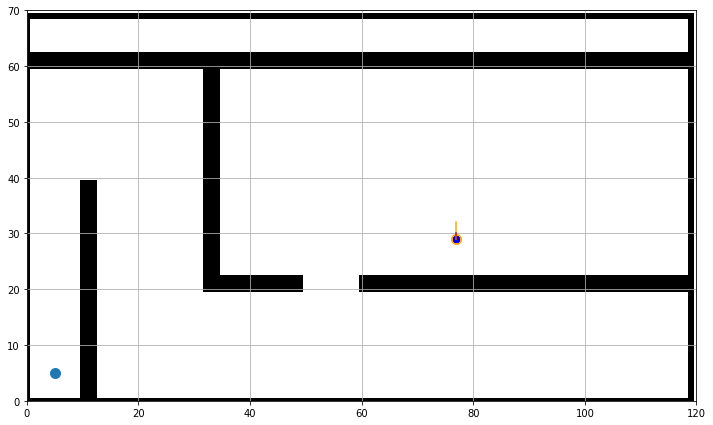

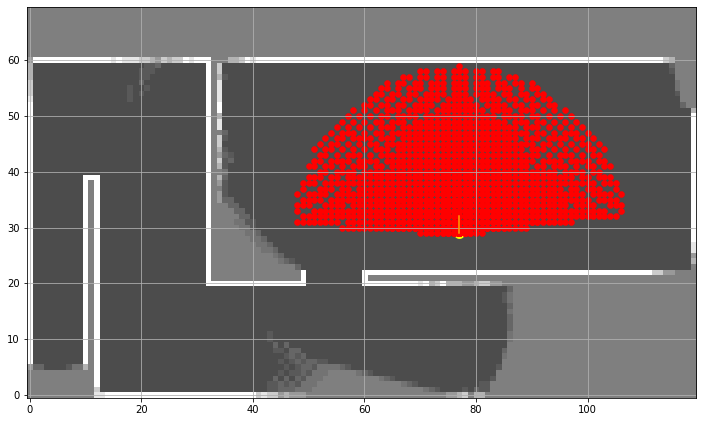

In [12]:
action_best_for_each_iteration = []  # the chosen pose for each iteration sep
MI_best_for_each_iteration = []  # the corresponding best mutual information for each iteration sep
H_m_init = cal_Hm(L) # current entropy
opti_start_time = time.time() 

for iteration in range(10):
  # ext_list = removeSameExtend(extend_list)   # consume too much time

  # (1) capture the frontier points *************************************************************************************
  loop_ext_start = time.time()
  frontier_list = []
  for ext in extended_this:

    if L[int(ext[0]),int(ext[1])]<0:  # not occupied

      x_cur = copy.deepcopy(ext[0])
      y_cur = copy.deepcopy(ext[1])

      frontier_true = False
      
      frontier_flag = 0
      for i in np.arange(-1,2,1):
        for j in np.arange(-1,2,1):
          x_cur_buf = x_cur + i
          y_cur_buf = y_cur + j

          for ext_judge in extended_this:
            if (np.array([x_cur_buf,y_cur_buf]) == ext_judge).all(): 
              frontier_flag = frontier_flag + 1

      if frontier_flag <= 5:  # an "edge" point
        frontier_true = True

      
      for i in np.arange(-4,4):      
        for j in np.arange(-4,4):
          x_cur_buf = x_cur + i
          y_cur_buf = y_cur + j
          if x_cur_buf<M and y_cur_buf<N:
            if L[int(x_cur_buf), int(y_cur_buf)] > 0:
              frontier_true = False 


      frontier_center = True
      if frontier_true: 
        if (len(frontier_list) == 0):
          frontier_list.append([ext])
          # print(ext)
        else:
          for frontier_list_mem in frontier_list:
            delta_dist = frontier_list_mem[0] - ext
            if math.hypot( delta_dist[0], delta_dist[1])< 3: 
              frontier_list_mem.append(ext)
              frontier_center = False
              break
          if frontier_center:
            frontier_list.append([ext]) 


  true_fig = plt.figure(figsize=(12,10))
  true_ax = true_fig.add_subplot(111)
  true_ax.set_xlim(0, N)
  true_ax.set_ylim(0, M)
  true_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
  true_ax.grid(True)
  true_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
  for fro in frontier_list:
    for fro_p in fro:
      true_ax.scatter(fro_p[1],fro_p[0],color='black',linewidths=0.5)
  for fro in frontier_list:
    true_ax.scatter(fro[0][1],fro[0][0],color='red',linewidths=4)
  loop_ext_end = time.time()
  print("time consuming of frontier capture：", loop_ext_end-loop_ext_start)


# (2) capture the candidates ******************************************************************************************************8

  loop_cand_start = time.time()

  candidate_list = []

  for frontier_center_hit in frontier_list:
    for yaw in np.arange(0, 2*math.pi, 2*math.pi/20):
      for move in np.arange(2,4): 

        candidate_flag = True

        x_ = frontier_center_hit[0][0] - move * math.cos(yaw);
        y_ = frontier_center_hit[0][1] - move * math.sin(yaw);
        x_ = round(x_)
        y_ = round(y_)
        extended_flag = False
        for ext_judge in extended_this:  
          if (np.array([x_,y_]) == ext_judge).all(): 
            extended_flag = True
            break
        if not extended_flag:  
          candidate_flag = False 

        if math.hypot(x_ - x[0,step] ,  y_ - x[1,step])  < 5  or math.hypot(x_ - x[0,step] ,  y_ - x[1,step])  > 35:   # 距离当前点太近或者太远不能成为候选点
          candidate_flag = False 

        # for frontier_center_hit_2 in frontier_list:  
        #   for frontier_center_hit_2_son in frontier_center_hit_2:
        #     if math.hypot(x_ - frontier_center_hit_2_son[0] ,  y_ - frontier_center_hit_2_son[1])  < 1.5: 
        #       candidate_flag = False 
        

        for i in np.arange(-4,4):      
          for j in np.arange(-4,4):
            x_buf = x_ + i
            y_buf = y_ + j
            if x_buf<M and y_buf<N and x_buf>0 and y_buf>0:
              if L[int(x_buf), int(y_buf)] > 0:
                candidate_flag = False
            else:
              candidate_flag = False  

        if candidate_flag:
          candidate_list.append([x_, y_, yaw])

  if len(candidate_list) == 0:   # if there is no candidate we back to some point before which can be perfected future
    max_candidate_secend = action_best[np.argsort(MI_best)[-1]]
    max_candidate_secend[2] =  max_candidate_secend[2] + math.pi/2
    candidate_list.append(max_candidate_secend)      
    

  true_fig = plt.figure(figsize=(12,10))
  true_ax = true_fig.add_subplot(111)
  true_ax.set_xlim(0, N)
  true_ax.set_ylim(0, M)
  true_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
  true_ax.grid(True)
  true_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)
        
  for candidater in candidate_list:
    true_ax.scatter(candidater[1],candidater[0],color='blue',linewidths=1)
    true_ax.plot([candidater[1], candidater[1]+1*math.sin(candidater[2])], [candidater[0], candidater[0]+1*math.cos(candidater[2])])

  # (3) calculate MI ********************************************************************************************************

  step = step + 1

  MI_update_list = []

  for candidater in candidate_list:
    L_copy = copy.deepcopy(L)

    x[0, step] = candidater[0]
    x[1, step] = candidater[1]
    x[2, step] = candidater[2]
    L_copy_updated = ray_casting_virtual(x, L_copy)

    HM_update = cal_Hm(L_copy_updated)

    MI_update = H_m_init - HM_update

    MI_update_list.append(MI_update)


  # the best candidate
  # max_candidator_index = np.argsort(MI_update_list) 
  # max_candidator = candidate_list[max_candidator_index[-1]]
  # log_fig = plt.figure(figsize=(12,10))
  # log_ax = log_fig.add_subplot(111)
  # log_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
  # log_ax.grid(True)

  # log_ax.scatter(max_candidator[1],max_candidator[0],color='yellow',linewidths=5)
  # log_ax.plot([max_candidator[1], max_candidator[1]+1*math.sin(max_candidator[2])], [max_candidator[0], max_candidator[0]+1*math.cos(max_candidator[2])],color='yellow')

  # log_ax.imshow(L+0.5, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)

  loop_cand_end = time.time()
  print("time consuming of candidate capture：", loop_cand_end-loop_cand_start)


  # (4) Bayesian Optimization *******************************************************************************************

  bay_start = time.time()

  beta = 1 # trad off "exploration" and "exploitation"
  # random.seed(22)

  # Gaussian process with Mat??rn kernel as surrogate model
  m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
  gpr = GaussianProcessRegressor(kernel=m52)

  n_iter = 10
  sample_num = 100 if 100<len(candidate_list) else len(candidate_list)   # please reduce the traning set
  random_index = random.sample(range(len(candidate_list)),sample_num)

  X_init = np.zeros((sample_num,3))
  Y_init = np.zeros((sample_num,1))
  for ccc in range(sample_num):  # TODO: suggest Sobol sequence for more "self" samples
    X_init[ccc,0] = candidate_list[random_index[ccc]][0]
    X_init[ccc,1] = candidate_list[random_index[ccc]][1]
    X_init[ccc,2] = candidate_list[random_index[ccc]][2]
    Y_init[ccc] = MI_update_list[random_index[ccc]]
  X_sample = copy.deepcopy(X_init)
  Y_sample = copy.deepcopy(Y_init)

  action_set = X_init
  action_best = []
  MI_best = []
  action_better_in_one_epoch = []
  MI_better_in_one_epoch = []

  candidate_with_max_acq = candidate_list[0]
  MI_with_max_acq = MI_update_list[0]


  for i in range(n_iter):

    # train GP
    gpr.fit(X_sample, Y_sample)
    mu, std = gpr.predict(np.array(candidate_list), return_std=True)
    # cal acquisition function (Ucb)
    acquisition = np.resize(mu,(len(candidate_list),)) + (beta * np.resize(std,(len(candidate_list),)))
    # sort
    candidate_with_max_acq_index = np.argsort(acquisition)[-1]
    candidate_with_max_acq = candidate_list[candidate_with_max_acq_index]
    
    MI_with_max_acq = MI_update_list[candidate_with_max_acq_index]
    action_best.append(candidate_with_max_acq)
    MI_best.append(MI_with_max_acq)

    # whether in training set
    flag_not_in = True
    for ii in range(X_sample.shape[0]):
      if (np.array(candidate_with_max_acq) == X_sample[ii,:]).all():
        flag_not_in = False
        break
    if flag_not_in:
      X_sample = np.append(X_sample,np.array(candidate_with_max_acq).reshape(1,3),axis=0)
      Y_sample = np.append(Y_sample, MI_with_max_acq)

  true_fig = plt.figure(figsize=(12,10))
  true_ax = true_fig.add_subplot(111)
  true_ax.set_xlim(0, N)
  true_ax.set_ylim(0, M)
  true_ax.scatter(x[0, 0],x[1, 0], linewidths=5)
  true_ax.grid(True)
  true_ax.imshow(np.subtract(1, true_map), cmap='gray', origin='lower', vmin=0.0, vmax=1.0)

  max_candidate_draw = copy.deepcopy(action_best[np.argsort(MI_best)[-1]])
  true_ax.scatter(max_candidate_draw[1],max_candidate_draw[0],color='orange',linewidths=5)
  true_ax.plot([max_candidate_draw[1], max_candidate_draw[1]+3*math.sin(max_candidate_draw[2])], [max_candidate_draw[0], max_candidate_draw[0]+3*math.cos(max_candidate_draw[2])],color='orange')
  MI_best_for_each_iteration.append( MI_best )

  sort_index_draw = np.argsort(MI_best)
  for ind_draw in sort_index_draw[-6:-2]:
    candidater2 = action_best[ind_draw]
    true_ax.scatter(candidater2[1],candidater2[0],color='blue',linewidths=1)
    true_ax.plot([candidater2[1], candidater2[1]+1*math.sin(candidater2[2])], [candidater2[0], candidater2[0]+1*math.cos(candidater2[2])])







  # ======================================================moving and mapping!!!!!!!!!!!!!!!!!!================================
  # Because we mitigate the effect of the traverse for the candidate choose, which should be perfected

  # mapping start point
  x_or = x[0, step-1]
  y_or = x[1, step-1]
  yaw_or = x[2, step-1]

  # mapping end point
  x_term = max_candidate_draw[0]
  y_term = max_candidate_draw[1]
  yaw_term = max_candidate_draw[2]

  # traverse point 
  traverse_array = GenericBresenhamLine(x_or,y_or, x_term,y_term)
  for travel in traverse_array:
    x[0, step] = travel[0]
    x[1, step] = travel[1]
    x[2, step] = yaw_term
    extended_this = ray_casting(x)

  # update entropy
  H_m_init = cal_Hm(L)
  
  log_fig = plt.figure(figsize=(12,10))
  log_ax = log_fig.add_subplot(111)
  log_ax.scatter(x[1, step],x[0, step], linewidths=5,color='yellow')
  log_ax.plot([max_candidate_draw[1], max_candidate_draw[1]+3*math.sin(max_candidate_draw[2])], [max_candidate_draw[0], max_candidate_draw[0]+3*math.cos(max_candidate_draw[2])],color='orange')
  log_ax.grid(True)
  for extended_this_p in extended_this:
    log_ax.scatter(extended_this_p[1],extended_this_p[0], linewidths=0.5,color='red')
  log_ax.imshow(L+0.5, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)


  bay_end = time.time()

  print("============================================================")

  action_best_for_each_iteration.append(max_candidate_draw)

opti_end_time = time.time()
print("time consuming of search trajectory", opti_end_time - opti_start_time)



# Exploration Results

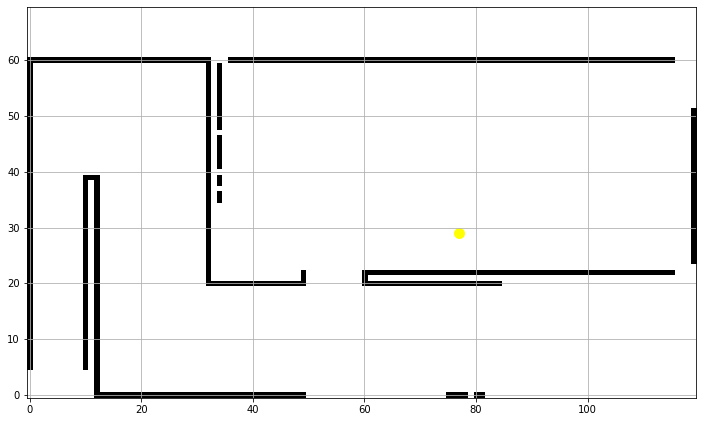

In [13]:
# the map condition from perception now
log_fig = plt.figure(figsize=(12,10))
log_ax = log_fig.add_subplot(111)
log_ax.scatter(x[1, step],x[0, step], linewidths=5,color='yellow')
log_ax.grid(True)

L2show = copy.deepcopy(L)
L2show[L2show>0] = 1
L2show[L2show<0] = 0
L2show[L2show==0] = 0.5

log_ax.imshow(1 - L2show, cmap='gray', origin='lower')

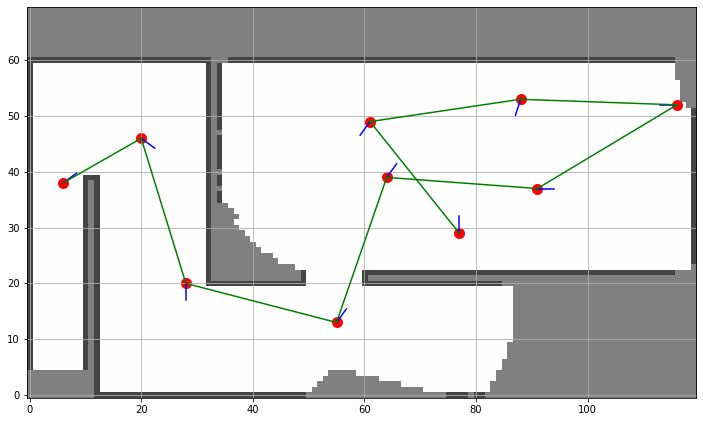

In [14]:
prob_fig = plt.figure(figsize=(12,10))
prob_ax = prob_fig.add_subplot(111)
prob_ax.grid(True)

L2show = copy.deepcopy(L)
m2show = copy.deepcopy(m)


for i in range(M):
  for j in range(N):
    l_show = L2show[i,j]
    if l_show<0:
      l_show = -5
    elif l_show>0:
      l_show = +1
    else:
      l_show=0
    m2show[i,j] =  math.exp(l_show) / ( 1 + math.exp(l_show) )


last_action = copy.deepcopy(action_best_for_each_iteration[0])
for action_ in action_best_for_each_iteration:
  prob_ax.scatter(action_[1],action_[0], linewidths=5,color='red')
  prob_ax.plot([action_[1], action_[1]+3*math.sin(action_[2])], [action_[0], action_[0]+3*math.cos(action_[2])],color='blue')
  prob_ax.plot([action_[1], last_action[1]], [action_[0], last_action[0]],color='green')
  last_action = copy.deepcopy(action_)
prob_ax.imshow(1-m2show, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)

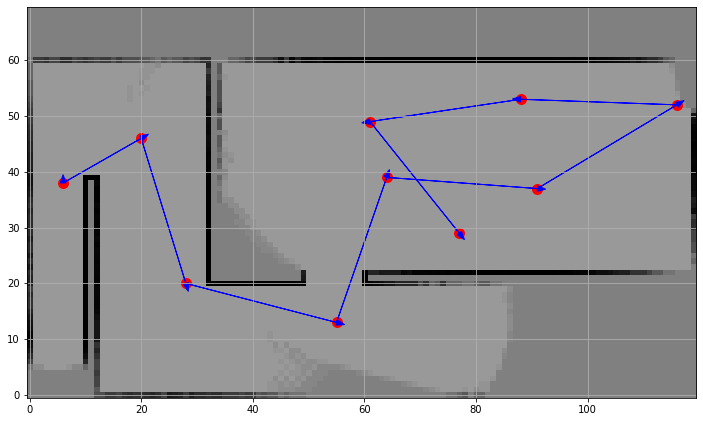

In [15]:
prob_fig = plt.figure(figsize=(12,10))
prob_ax = prob_fig.add_subplot(111)
prob_ax.grid(True)

L2show = copy.deepcopy(L)
m2show = copy.deepcopy(m)


for i in range(M):
  for j in range(N):
    l_show = L2show[i,j]
    if l_show<0:
      l_show = 2*l_show
    elif l_show>0:
      l_show = 2*l_show
    else:
      l_show=0
    m2show[i,j] =  math.exp(l_show) / ( 1 + math.exp(l_show) )


last_action = copy.deepcopy(action_best_for_each_iteration[0])
for action_ in action_best_for_each_iteration:
  prob_ax.scatter(action_[1],action_[0], linewidths=5,color='red')
  # prob_ax.plot([action_[1], action_[1]+3*math.sin(action_[2])], [action_[0], action_[0]+3*math.cos(action_[2])],color='blue')
  prob_ax.arrow(last_action[1], last_action[0], action_[1]-last_action[1],action_[0]-last_action[0],color='blue',head_width=1)
  last_action = copy.deepcopy(action_)
prob_ax.imshow(1-m2show, cmap='gray', origin='lower', vmin=0.0, vmax=1.0)